# Lab 3 

## Task 2: Feature Detection and Matching

In [5]:
# Install required packages

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from pathlib import Path

In [6]:
# Images paths, pairs 
base = Path("/Users/natalia/Documents/LTU_Master/Computer_vision/Lab3/lab3")
pairs = [
    (base/"left.jpg",        base/"right.jpg"),
    (base/"notre_dame1.jpg", base/"notre_dame2.jpg"),
]

# Convert the images to Color and Grayscale
def read_gray_color(p: Path):
    c = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if c is None: raise FileNotFoundError(p)
    g = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
    return g, c

# load images
left_gray,  left_color  = read_gray_color(base/"left.jpg")
right_gray, right_color = read_gray_color(base/"right.jpg")
nd1_gray,   nd1_color   = read_gray_color(base/"notre_dame1.jpg")
nd2_gray,   nd2_color   = read_gray_color(base/"notre_dame2.jpg")


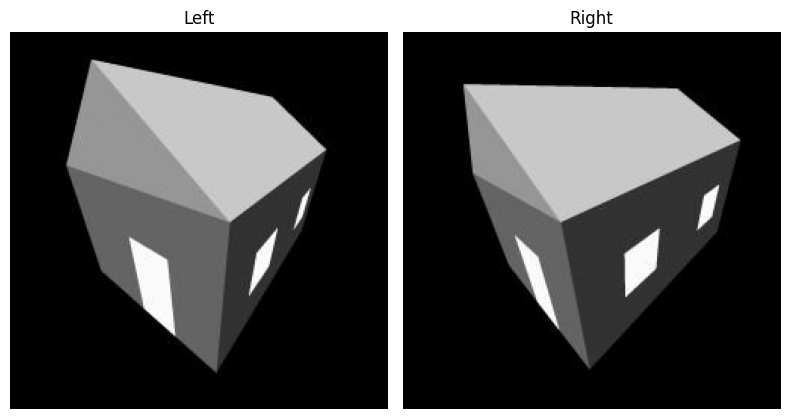

In [7]:
# Show images left-right
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(left_gray, cmap='gray')
plt.title("Left")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(right_gray, cmap='gray')
plt.title("Right")
plt.axis('off')
plt.tight_layout()

plt.show()

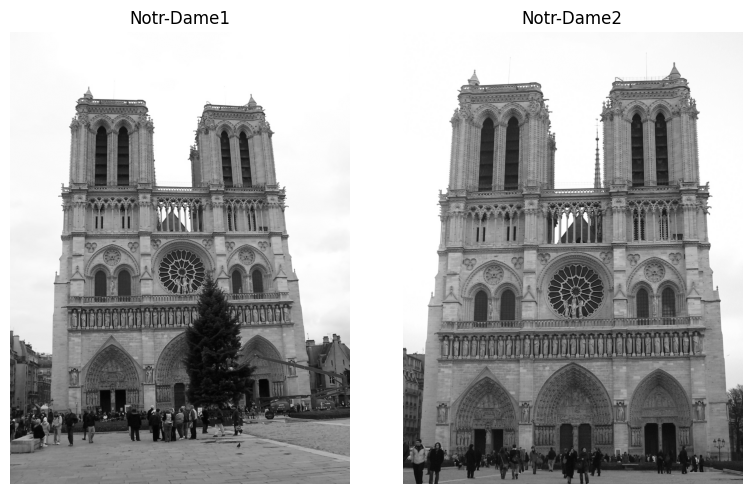

In [8]:
# Show images notr-dame
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(nd1_gray, cmap='gray')
plt.title("Notr-Dame1")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(nd2_gray, cmap='gray')
plt.title("Notr-Dame2")
plt.axis('off')
plt.tight_layout()

plt.show()

In [9]:
# Harris Corner detector

# Parameters 
def harris_corners(
    gray,                   # image in grayscale
    k=0.05,
    sigma=1.5,
    nms_ksize=3,
    corner_thresh_rel=0.05, # relative to max(R>0)
    edge_thresh_rel=0.05,   # relative to max(-R) for R<0
    refine=False
):
    """
    Returns:
        corners_xy : local maxima of R above corner_thresh
        edges_xy   : local minima of R below -edge_thresh
        R          : raw Harris response
        Rn         : normalized 0..1
    """

    # to float32 in [0,1]
    g = gray.astype(np.float32)
    if g.max() > 1:
        g /= 255.0

    # Sobel kernel 3x3
    Ix = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REFLECT_101)
    Iy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REFLECT_101)

    # Tensor smoothing
    Ixx = cv2.GaussianBlur(Ix*Ix, (0,0), sigma)
    Iyy = cv2.GaussianBlur(Iy*Iy, (0,0), sigma)
    Ixy = cv2.GaussianBlur(Ix*Iy, (0,0), sigma)

    # Harris response
    detM   = Ixx*Iyy - Ixy*Ixy
    traceM = Ixx + Iyy
    R      = detM - k*(traceM**2)

    # normalized (for reference/plots)
    Rn = (R - R.min()) / (R.max() - R.min() + 1e-12)

    # NMS kernel
    if nms_ksize % 2 == 0:
        nms_ksize += 1
    kernel = np.ones((nms_ksize, nms_ksize), np.uint8)

    # CORNERS: local maxima of R, above threshold
    Rpos_max = max(float(R.max()), 0.0)
    c_thr = corner_thresh_rel * (Rpos_max + 1e-12)
    R_dil = cv2.dilate(R, kernel)  # local max filter
    corners_mask = (R == R_dil) & (R > c_thr)

    # EDGES: local minima of R (maxima of -R), below -threshold
    Rneg_max = float(np.max(-R))            # = -min(R)
    e_thr = edge_thresh_rel * (Rneg_max + 1e-12)
    m_dil = cv2.dilate(-R, kernel)          # local max of (-R) => local min of R
    edges_mask = ((-R) == m_dil) & (R < -e_thr)

    # Connected components -> centroids
    def centroids(mask):
        mask_u8 = mask.astype(np.uint8)
        num, _, _, cents = cv2.connectedComponentsWithStats(mask_u8, connectivity=8)
        return cents[1:].astype(int) if num > 1 else np.empty((0,2), int)

    corners_xy = centroids(corners_mask)
    edges_xy   = centroids(edges_mask)

    return corners_xy, edges_xy, R, Rn


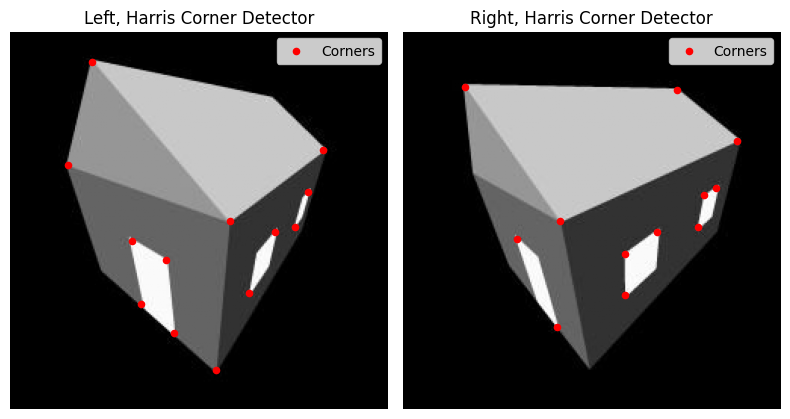

In [10]:
# Harris Corner Detector

corners_xy_left, edges_xy_left, R_left, Rn_left = harris_corners(
    left_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

corners_xy_right, edges_xy_right, R_right, Rn_right = harris_corners(
    right_gray, k=0.05, sigma=1.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.001,  
    refine=False
)

# Scatter-plot for edges and corners 


# Show images left-right
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(left_gray, cmap='gray')
#if len(edges_xy_left):
    #plt.scatter(edges_xy_left[:,0], edges_xy_left[:,1], s=10, c='c', label='Edges')
if len(corners_xy_left):
    plt.scatter(corners_xy_left[:,0], corners_xy_left[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Left, Harris Corner Detector")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(right_gray, cmap='gray')
#if len(edges_xy_right):
    #plt.scatter(edges_xy_right[:,0], edges_xy_right[:,1], s=10, c='c', label='Edges')
if len(corners_xy_right):
    plt.scatter(corners_xy_right[:,0], corners_xy_right[:,1], s=20, c='r', label='Corners')
plt.legend()
plt.title("Right, Harris Corner Detector")
plt.axis('off')
plt.tight_layout()

plt.show()


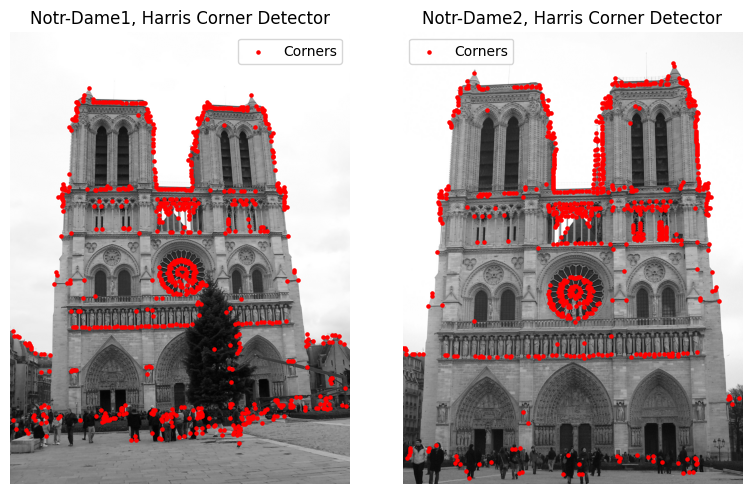

In [11]:
# Harris Corner Detector Notr-Dame

corners_xy_left, edges_xy_left, R_left, Rn_left = harris_corners(
    nd1_gray, k=0.05, sigma=2.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.1,  
    refine=False
)

corners_xy_right, edges_xy_right, R_right, Rn_right = harris_corners(
    nd2_gray, k=0.05, sigma=2.5,
    nms_ksize=7,
    corner_thresh_rel=0.05,  
    edge_thresh_rel=0.1,  
    refine=False
)

# Scatter-plot for edges and corners 


# Show images left-right
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.imshow(nd1_gray, cmap='gray')
#if len(edges_xy_left):
    #plt.scatter(edges_xy_left[:,0], edges_xy_left[:,1], s=10, c='c', label='Edges')
if len(corners_xy_left):
    plt.scatter(corners_xy_left[:,0], corners_xy_left[:,1], s=5, c='r', label='Corners')
plt.legend()
plt.title("Notr-Dame1, Harris Corner Detector")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(nd2_gray, cmap='gray')
#if len(edges_xy_right):
    #plt.scatter(edges_xy_right[:,0], edges_xy_right[:,1], s=10, c='c', label='Edges')
if len(corners_xy_right):
    plt.scatter(corners_xy_right[:,0], corners_xy_right[:,1], s=5, c='r', label='Corners')
plt.legend()
plt.title("Notr-Dame2, Harris Corner Detector")
plt.axis('off')
plt.tight_layout()

plt.show()


Harris+SIFT keypoints: Left=17  Right=16
F-RANSAC -> good=11  inliers=7  ratio=0.64
H-RANSAC -> good=11  inliers=6  ratio=0.55


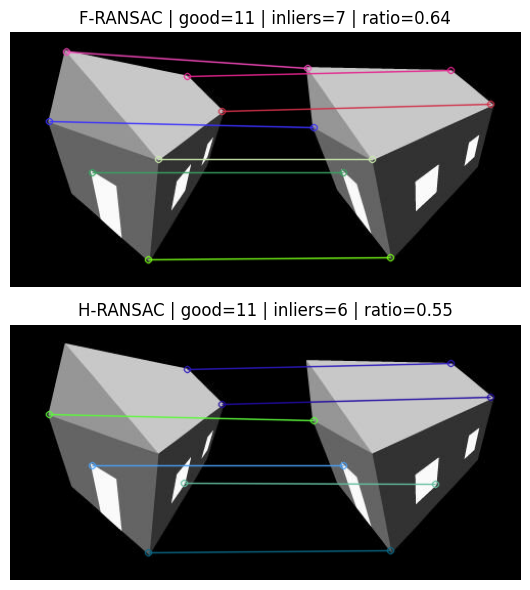

In [18]:
# HARRIS detector + SIFT descriptor 

# Harris corners 
k_h, sigma_h, nms_h = 0.01, 2.5, 7
corners_L, _, _, _ = harris_corners(left_gray,  k=k_h, sigma=sigma_h, nms_ksize=nms_h,
                                    corner_thresh_rel=0.005, edge_thresh_rel=0.001, refine=False)
corners_R, _, _, _ = harris_corners(right_gray, k=k_h, sigma=sigma_h, nms_ksize=nms_h,
                                    corner_thresh_rel=0.005, edge_thresh_rel=0.001, refine=False)

# Convert Harris points to cv2.KeyPoint (SIFT needs KeyPoint objects)
def to_keypoints(cxy, size):
    return [cv2.KeyPoint(float(x), float(y), float(size)) for x, y in cxy]

kp_size = 0.5 * sigma_h          # simple scale for the descriptor window
kp_L = to_keypoints(corners_L, kp_size)
kp_R = to_keypoints(corners_R, kp_size)

# SIFT descriptors at those points (SIFT will assign orientation)
sift = cv2.SIFT_create()
kp_L, des_L = sift.compute(left_gray,  kp_L)
kp_R, des_R = sift.compute(right_gray, kp_R)

print(f"Harris+SIFT keypoints: Left={len(kp_L)}  Right={len(kp_R)}")

# Match (BF + Lowe ratio) and RANSAC inlier filtering
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
knn = bf.knnMatch(des_L, des_R, k=2)
good = [m for m, n in knn if m.distance < 0.75 * n.distance]

# Points from good matches
ptsL = np.float32([kp_L[m.queryIdx].pt  for m in good])
ptsR = np.float32([kp_R[m.trainIdx].pt for m in good])

# Fundamental matrix RANSAC (3D scenes)
F, maskF = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_RANSAC,
                                  ransacReprojThreshold=1.0, confidence=0.99)
inliersF = [m for m, keep in zip(good, (maskF.ravel().astype(bool) if maskF is not None else [])) if keep]
ratioF   = len(inliersF) / max(len(good), 1)

# Homography RANSAC (planar / pure rotation)
H, maskH = cv2.findHomography(ptsL, ptsR, cv2.RANSAC, ransacReprojThreshold=3.0)
inliersH = [m for m, keep in zip(good, (maskH.ravel().astype(bool) if maskH is not None else [])) if keep]
ratioH   = len(inliersH) / max(len(good), 1)

print(f"F-RANSAC -> good={len(good)}  inliers={len(inliersF)}  ratio={ratioF:.2f}")
print(f"H-RANSAC -> good={len(good)}  inliers={len(inliersH)}  ratio={ratioH:.2f}")

# Visualize BOTH results side-by-side (draw inliers only)
visF = cv2.drawMatches(left_gray, kp_L, right_gray, kp_R,
                       sorted(inliersF, key=lambda m: m.distance)[:60],
                       None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
visH = cv2.drawMatches(left_gray, kp_L, right_gray, kp_R,
                       sorted(inliersH, key=lambda m: m.distance)[:60],
                       None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axes = plt.subplots(2, 1, figsize=(14, 6))
axes[0].imshow(cv2.cvtColor(visF, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"F-RANSAC | good={len(good)} | inliers={len(inliersF)} | ratio={ratioF:.2f}")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(visH, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"H-RANSAC | good={len(good)} | inliers={len(inliersH)} | ratio={ratioH:.2f}")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Harris+SIFT (ND): kp1=4844, kp2=4921
ND F-RANSAC -> good=540  inliers=296  ratio=0.55
ND H-RANSAC -> good=540  inliers=230  ratio=0.43


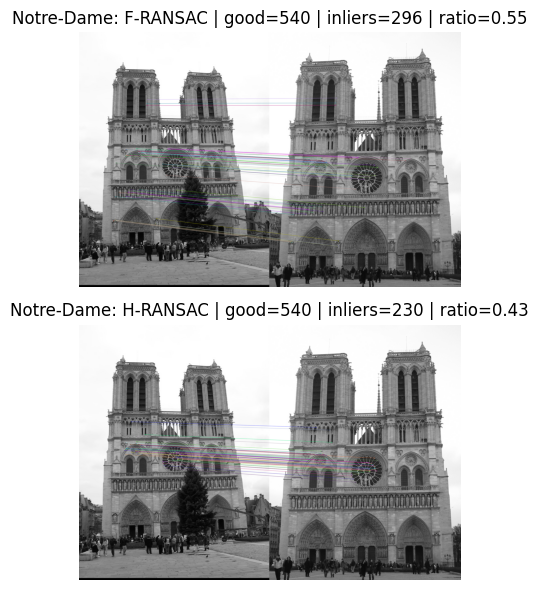

In [19]:

# Harris corners on Notre-Dame 

k_h, sigma_h, nms_h = 0.01, 1.5, 3
corners_ND1, _, _, _ = harris_corners(
    nd1_gray, k=k_h, sigma=sigma_h, nms_ksize=nms_h,
    corner_thresh_rel=0.005, edge_thresh_rel=0.001, refine=False
)
corners_ND2, _, _, _ = harris_corners(
    nd2_gray, k=k_h, sigma=sigma_h, nms_ksize=nms_h,
    corner_thresh_rel=0.005, edge_thresh_rel=0.001, refine=False
)

def to_keypoints(cxy, size):
    return [cv2.KeyPoint(float(x), float(y), float(size)) for x, y in cxy]

# Slightly larger window helps on repetitive façades
kp_size = 5 * sigma_h
kp_ND1 = to_keypoints(corners_ND1, kp_size)
kp_ND2 = to_keypoints(corners_ND2, kp_size)

# SIFT descriptors at those points
sift = cv2.SIFT_create()
kp_ND1, des_ND1 = sift.compute(nd1_gray, kp_ND1)
kp_ND2, des_ND2 = sift.compute(nd2_gray, kp_ND2)
print(f"Harris+SIFT (ND): kp1={len(kp_ND1)}, kp2={len(kp_ND2)}")

# BF + Lowe ratio 
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
knn = bf.knnMatch(des_ND1, des_ND2, k=2)
good = [m for m, n in knn if m.distance < 0.75 * n.distance]

# Guard if too few matches
if len(good) < 4:
    print(f"Too few matches: good={len(good)}"); 
else:
    # Build point arrays
    pts1 = np.float32([kp_ND1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp_ND2[m.trainIdx].pt for m in good])

    # Fundamental matrix RANSAC (3D) 
    F, maskF = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC,
                                      ransacReprojThreshold=1.0, confidence=0.99)
    inliersF = [m for m, keep in zip(good, (maskF.ravel().astype(bool) if maskF is not None else [])) if keep]
    ratioF = len(inliersF) / max(len(good), 1)

    # Homography RANSAC (planar/pure rotation)
    H, maskH = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacReprojThreshold=3.0)
    inliersH = [m for m, keep in zip(good, (maskH.ravel().astype(bool) if maskH is not None else [])) if keep]
    ratioH = len(inliersH) / max(len(good), 1)

    print(f"ND F-RANSAC -> good={len(good)}  inliers={len(inliersF)}  ratio={ratioF:.2f}")
    print(f"ND H-RANSAC -> good={len(good)}  inliers={len(inliersH)}  ratio={ratioH:.2f}")

    # Visualize both (draw inliers only)
    visF = cv2.drawMatches(nd1_gray, kp_ND1, nd2_gray, kp_ND2,
                           sorted(inliersF, key=lambda m: m.distance)[:60],
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    visH = cv2.drawMatches(nd1_gray, kp_ND1, nd2_gray, kp_ND2,
                           sorted(inliersH, key=lambda m: m.distance)[:60],
                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    axes[0].imshow(cv2.cvtColor(visF, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Notre-Dame: F-RANSAC | good={len(good)} | inliers={len(inliersF)} | ratio={ratioF:.2f}")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(visH, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Notre-Dame: H-RANSAC | good={len(good)} | inliers={len(inliersH)} | ratio={ratioH:.2f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


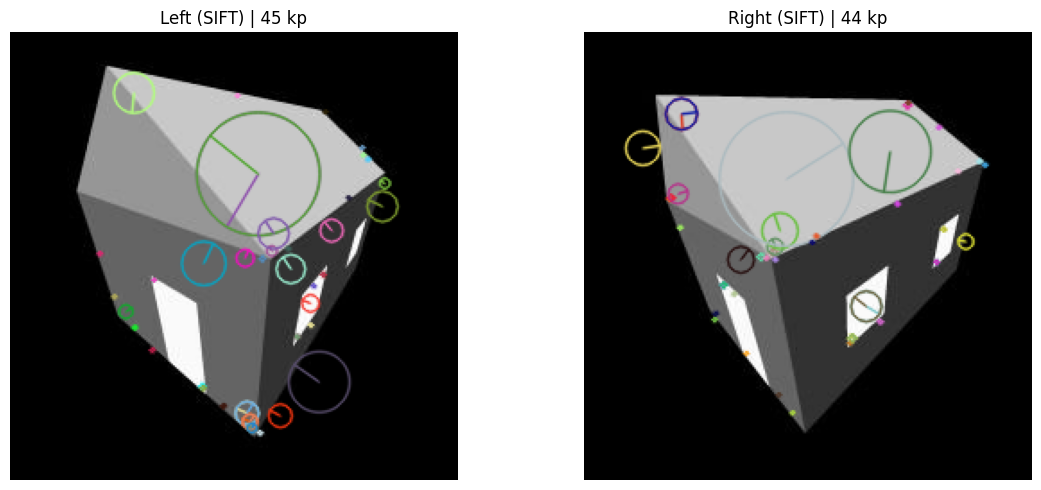

In [14]:
# SIFT (detector)
sift = cv2.SIFT_create()

kp_left,  des_left  = sift.detectAndCompute(left_gray,  None)
kp_right, des_right = sift.detectAndCompute(right_gray, None)

# Visualize keypoints (rich circles show scale + orientation)
vis_left  = cv2.drawKeypoints(left_gray,  kp_left,  None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_right = cv2.drawKeypoints(right_gray, kp_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# BGR->RGB for Matplotlib
vis_left  = cv2.cvtColor(vis_left,  cv2.COLOR_BGR2RGB)
vis_right = cv2.cvtColor(vis_right, cv2.COLOR_BGR2RGB)


# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(vis_left);  axes[0].set_title(f"Left (SIFT) | {len(kp_left)} kp");   axes[0].axis("off")
axes[1].imshow(vis_right); axes[1].set_title(f"Right (SIFT) | {len(kp_right)} kp"); axes[1].axis("off")
plt.tight_layout()
plt.show()


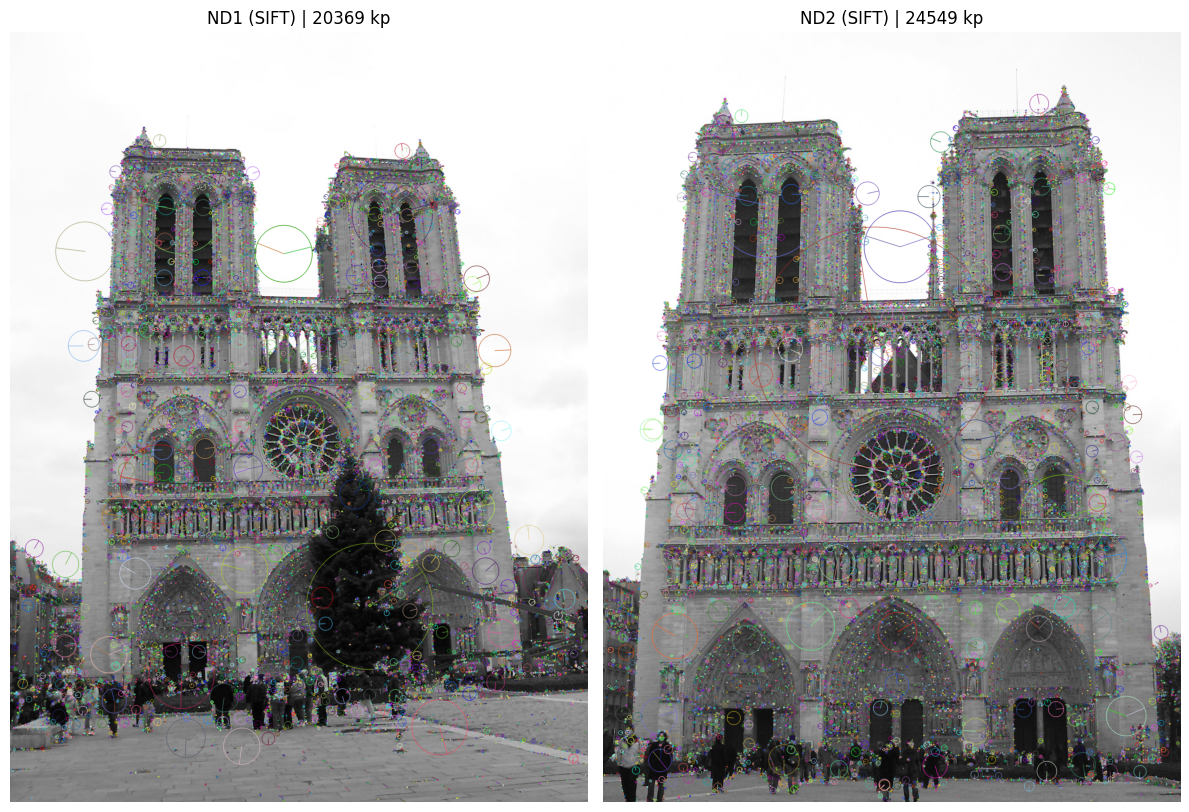

In [15]:
# SIFT (detector)
sift = cv2.SIFT_create()

kp_nd1,   des_nd1   = sift.detectAndCompute(nd1_gray,   None)
kp_nd2,   des_nd2   = sift.detectAndCompute(nd2_gray,   None)

# Visualize keypoints (rich circles show scale + orientation)
vis_nd1   = cv2.drawKeypoints(nd1_gray,   kp_nd1,   None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_nd2   = cv2.drawKeypoints(nd2_gray,   kp_nd2,   None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# BGR->RGB for Matplotlib

vis_nd1  = cv2.cvtColor(vis_nd1,  cv2.COLOR_BGR2RGB)
vis_nd2  = cv2.cvtColor(vis_nd2,   cv2.COLOR_BGR2RGB)


# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
axes[0].imshow(vis_nd1);   axes[0].set_title(f"ND1 (SIFT) | {len(kp_nd1)} kp");     axes[0].axis("off")
axes[1].imshow(vis_nd2);   axes[1].set_title(f"ND2 (SIFT) | {len(kp_nd2)} kp");     axes[1].axis("off")
plt.tight_layout()
plt.show()


SIFT: left=45, right=44
Good (after ratio=0.75): 20
F-RANSAC  -> good=20, inliers=12, inlier ratio=0.60
H-RANSAC  -> good=20, inliers=4, inlier ratio=0.20


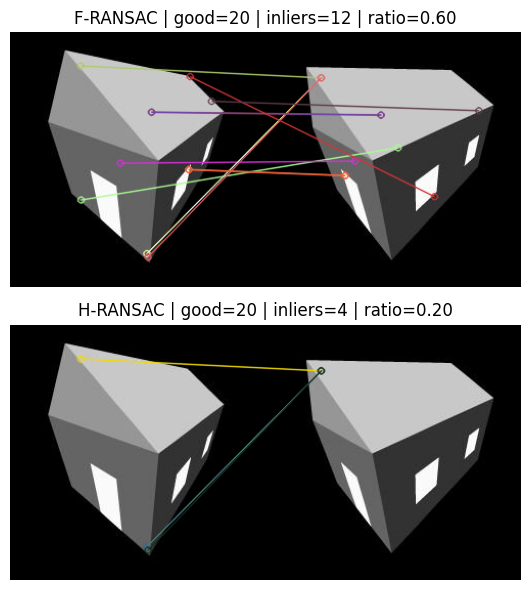

In [ ]:
# SIFT-SIFT
# SIFT keypoints + descriptors
sift = cv2.SIFT_create()
kp_left,  des_left  = sift.detectAndCompute(left_gray,  None)
kp_right, des_right = sift.detectAndCompute(right_gray, None)
print(f"SIFT: left={len(kp_left)}, right={len(kp_right)}")

# KNN + Lowe ratio test (descriptor metric = L2)
ratio = 0.75
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
knn = bf.knnMatch(des_left, des_right, k=2)
good = [m for (m, n) in knn if m.distance < ratio * n.distance]
print(f"Good (after ratio={ratio}): {len(good)}")

# Guard
if len(good) < 4:
    print("Too few matches for RANSAC.")
else:
    # Points from good matches
    ptsL = np.float32([kp_left[m.queryIdx].pt  for m in good])
    ptsR = np.float32([kp_right[m.trainIdx].pt for m in good])

    def ransac_report(pts1, pts2, good, model="F", thr=1.0, conf=0.99):
        need = 8 if model.upper()=="F" else 4
        if len(good) < need:
            return 0, 0.0, None, None  # inliers, ratio, model_matrix, keep_mask

        if model.upper() == "F":
            M, mask = cv2.findFundamentalMat(
                pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=thr, confidence=conf
            )
        elif model.upper() == "H":
            M, mask = cv2.findHomography(
                pts1, pts2, cv2.RANSAC, ransacReprojThreshold=thr
            )
        else:
            raise ValueError("model must be 'F' or 'H'")

        if mask is None:
            return 0, 0.0, M, None

        keep = mask.ravel().astype(bool)
        inliers = int(keep.sum())
        ratio = inliers / max(len(good), 1)
        return inliers, ratio, M, keep

    # Fundamental matrix RANSAC (3D scenes) 
    inl_F, ratio_F, F, keepF = ransac_report(ptsL, ptsR, good, model="F", thr=1.0, conf=0.99)
    print(f"F-RANSAC  -> good={len(good)}, inliers={inl_F}, inlier ratio={ratio_F:.2f}")

    # Homography RANSAC (planar / pure rotation) 
    inl_H, ratio_H, H, keepH = ransac_report(ptsL, ptsR, good, model="H", thr=3.0)
    print(f"H-RANSAC  -> good={len(good)}, inliers={inl_H}, inlier ratio={ratio_H:.2f}")

    # Visualize inliers for each model
    to_draw_F = [m for m, k in zip(good, (keepF if keepF is not None else [])) if k][:60]
    to_draw_H = [m for m, k in zip(good, (keepH if keepH is not None else [])) if k][:60]

    visF = cv2.drawMatches(
        left_gray, kp_left, right_gray, kp_right,
        to_draw_F, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    visH = cv2.drawMatches(
        left_gray, kp_left, right_gray, kp_right,
        to_draw_H, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    axes[0].imshow(cv2.cvtColor(visF, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"F-RANSAC | good={len(good)} | inliers={inl_F} | ratio={ratio_F:.2f}")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(visH, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"H-RANSAC | good={len(good)} | inliers={inl_H} | ratio={ratio_H:.2f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


SIFT (ND): nd1=20369, nd2=24549
Good (after ratio=0.75): 1665
ND F-RANSAC -> good=1665, inliers=789, inlier ratio=0.47
ND H-RANSAC -> good=1665, inliers=400, inlier ratio=0.24


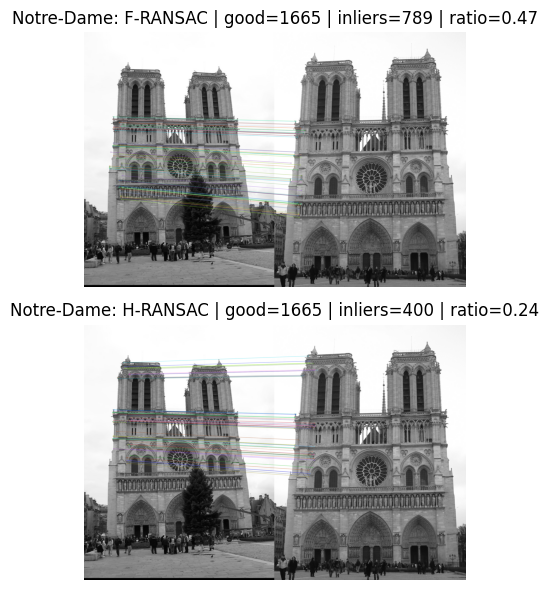

In [ ]:
# SIFT keypoints + descriptors (Notre-Dame)
sift = cv2.SIFT_create()
kp_nd1, des_nd1 = sift.detectAndCompute(nd1_gray, None)
kp_nd2, des_nd2 = sift.detectAndCompute(nd2_gray, None)
print(f"SIFT (ND): nd1={len(kp_nd1)}, nd2={len(kp_nd2)}")

# KNN + Lowe ratio test (descriptor metric = L2)
ratio = 0.75
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
knn = bf.knnMatch(des_nd1, des_nd2, k=2)
good = [m for (m, n) in knn if m.distance < ratio * n.distance]
print(f"Good (after ratio={ratio}): {len(good)}")

if len(good) < 4:
    print("Too few matches for RANSAC.")
else:
    # Points from good matches
    pts1 = np.float32([kp_nd1[m.queryIdx].pt  for m in good])
    pts2 = np.float32([kp_nd2[m.trainIdx].pt for m in good])

    def ransac_report(ptsA, ptsB, good, model="F", thr=1.0, conf=0.99):
        need = 8 if model.upper()=="F" else 4
        if len(good) < need:
            return 0, 0.0, None, None  # inliers, ratio, model_matrix, keep_mask

        if model.upper() == "F":
            M, mask = cv2.findFundamentalMat(
                ptsA, ptsB, cv2.FM_RANSAC, ransacReprojThreshold=thr, confidence=conf
            )
        elif model.upper() == "H":
            M, mask = cv2.findHomography(
                ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold=thr
            )
        else:
            raise ValueError("model must be 'F' or 'H'")

        if mask is None:
            return 0, 0.0, M, None

        keep = mask.ravel().astype(bool)
        inliers = int(keep.sum())
        ratio_val = inliers / max(len(good), 1)
        return inliers, ratio_val, M, keep

    # Fundamental Matrix RANSAC (general 3D) 
    inl_F, ratio_F, F, keepF = ransac_report(pts1, pts2, good, model="F", thr=1.0, conf=0.99)
    print(f"ND F-RANSAC -> good={len(good)}, inliers={inl_F}, inlier ratio={ratio_F:.2f}")

    # Homography RANSAC (planar / pure rotation)
    inl_H, ratio_H, H, keepH = ransac_report(pts1, pts2, good, model="H", thr=3.0)
    print(f"ND H-RANSAC -> good={len(good)}, inliers={inl_H}, inlier ratio={ratio_H:.2f}")

    # Visualize inliers for each model (side-by-side)
    to_draw_F = [m for m, k in zip(good, (keepF if keepF is not None else [])) if k][:60]
    to_draw_H = [m for m, k in zip(good, (keepH if keepH is not None else [])) if k][:60]

    visF = cv2.drawMatches(
        nd1_gray, kp_nd1, nd2_gray, kp_nd2,
        to_draw_F, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    visH = cv2.drawMatches(
        nd1_gray, kp_nd1, nd2_gray, kp_nd2,
        to_draw_H, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    axes[0].imshow(cv2.cvtColor(visF, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Notre-Dame: F-RANSAC | good={len(good)} | inliers={inl_F} | ratio={ratio_F:.2f}")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(visH, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Notre-Dame: H-RANSAC | good={len(good)} | inliers={inl_H} | ratio={ratio_H:.2f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
